# Automatic Modulation Classification

### FOR DATA SET

#### https://www.deepsig.ai/datasets/
#### RADIOML 2016.04.C

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers,models
import numpy as np 
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, AveragePooling2D, Flatten, GaussianNoise, Dense, Activation

## DataSet

### Modulation(11) X SNR(20) X No._Of_Samples(500+) X 2(I/Q) X 128(Points)
### {'BPSK', 'WBFM', 'PAM4', 'QPSK', '8PSK', 'CPFSK', 'QAM16', 'AM-DSB', 'GFSK', 'QAM64', 'AM-SSB'}
### {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2}

In [2]:
import pickle

with open('2016.04C.multisnr.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print("Keys in the data:", data.keys())
a = []
b = []
for key in data.keys():
    a.append(key[0])
    b.append(key[1])
    print(f"Shape of {key}: {data[key].shape}")

Keys in the data: dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('PAM4', 18), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('8PSK', -18), ('PAM4', -6), ('WBFM', -18), ('BPSK', 8), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('AM-DSB', -18), ('QPSK', 8), ('PAM4', 14), ('WBFM', -8), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('8PSK', -10), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('WBFM', -14), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('QAM16', 8), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('

In [3]:
print(set(a))
print(set(b))

{'QAM64', 'CPFSK', '8PSK', 'BPSK', 'QAM16', 'PAM4', 'AM-SSB', 'AM-DSB', 'WBFM', 'QPSK', 'GFSK'}
{0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2}


## Plot Data

705


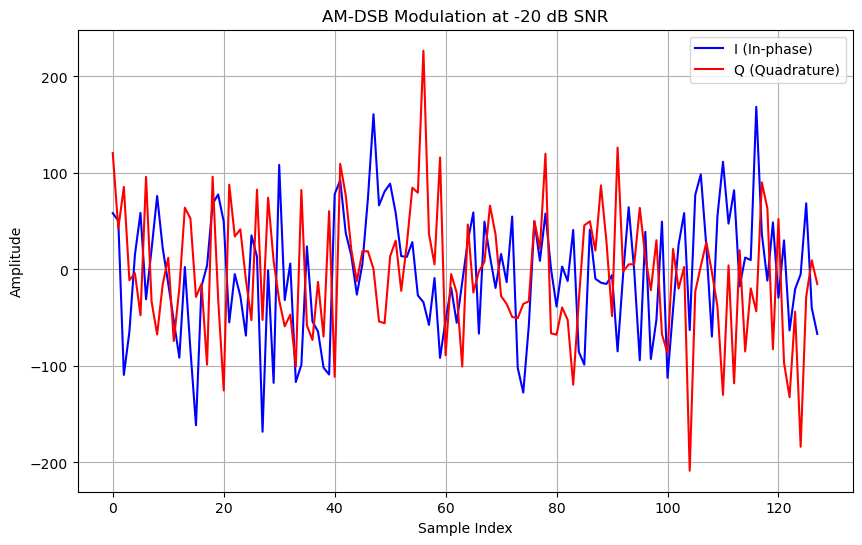

705


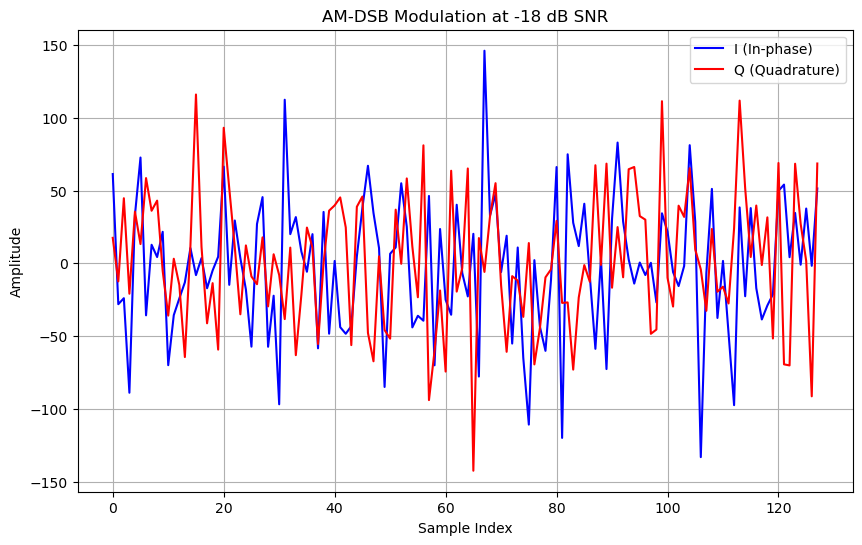

705


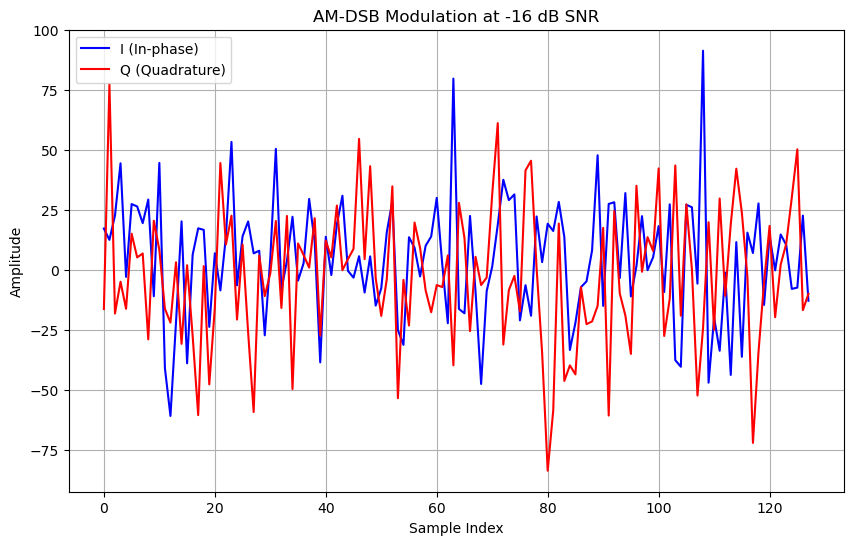

705


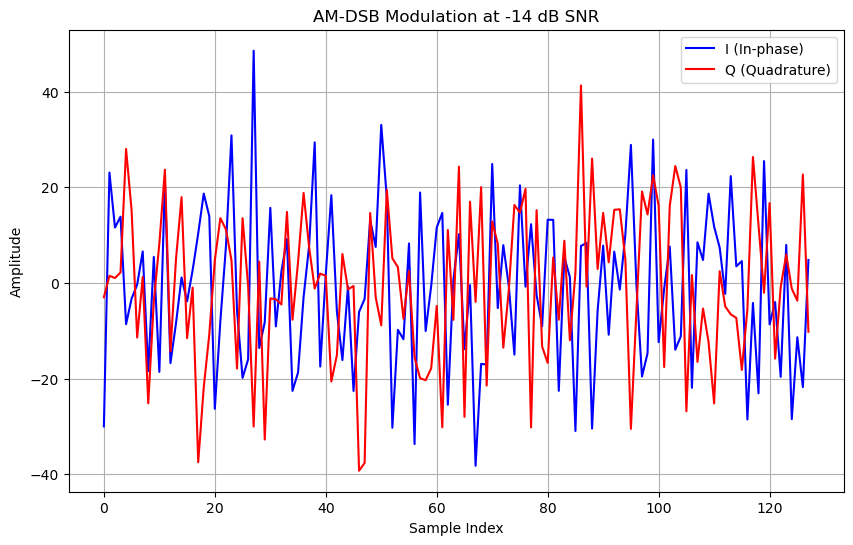

705


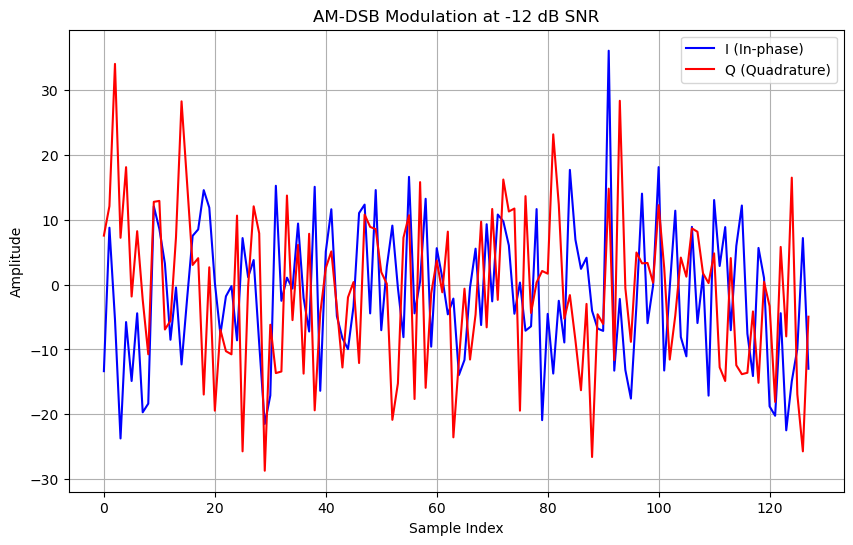

705


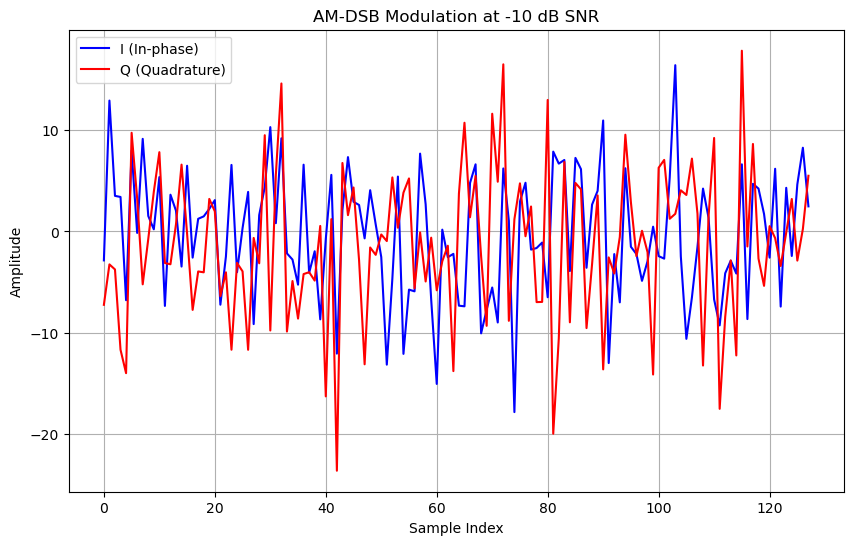

705


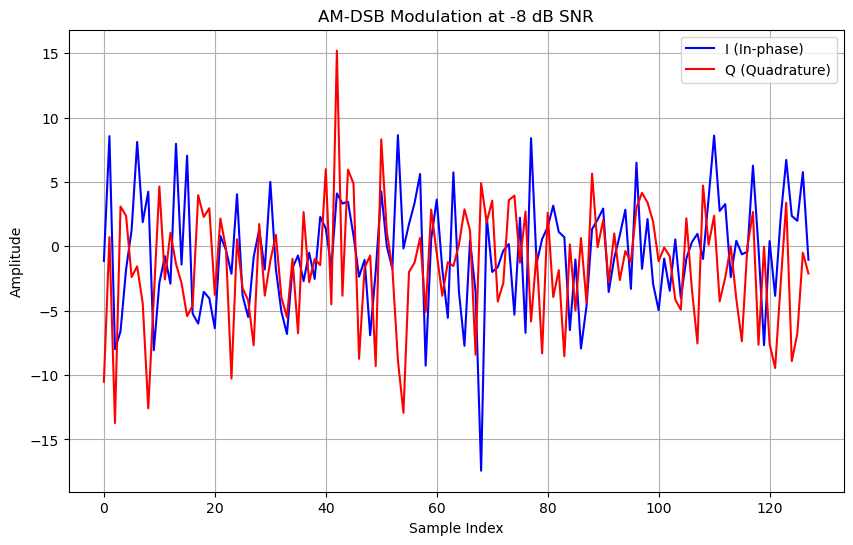

705


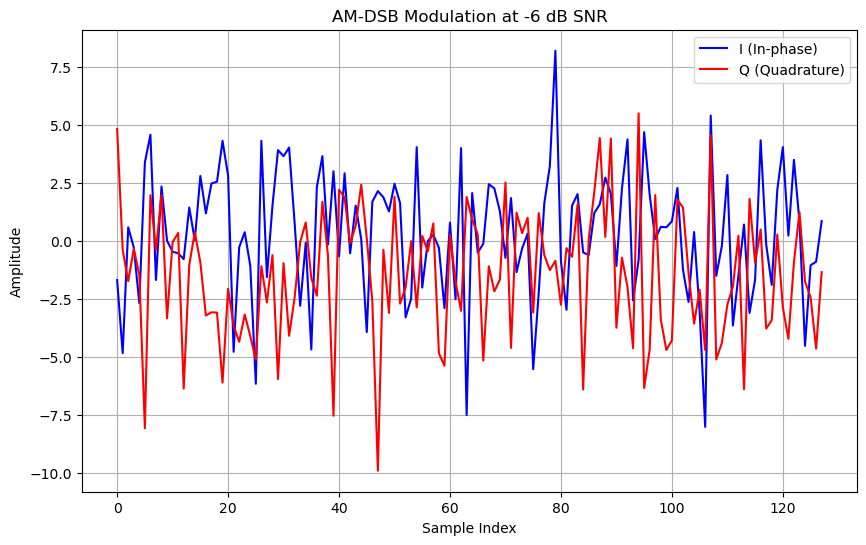

705


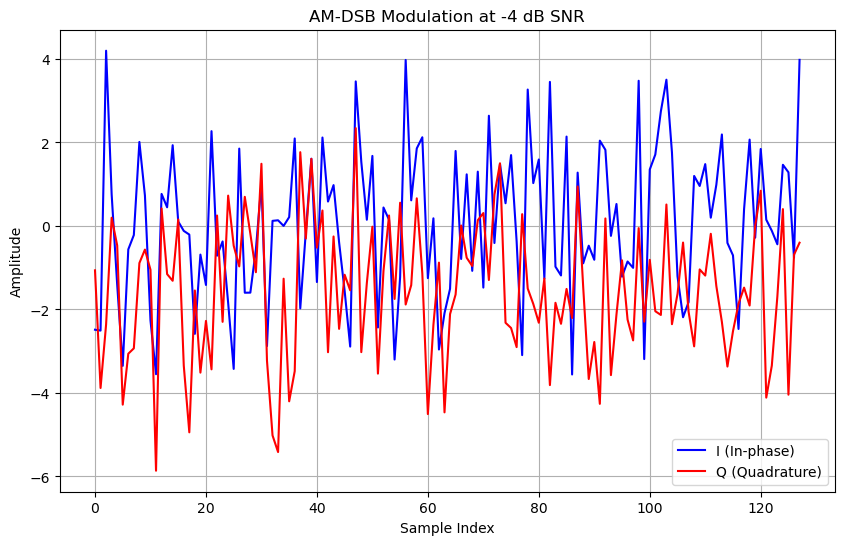

705


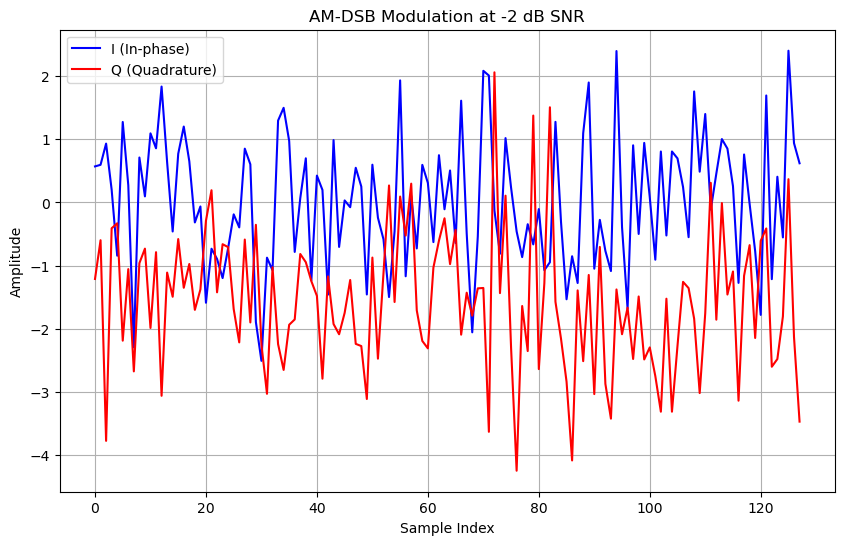

705


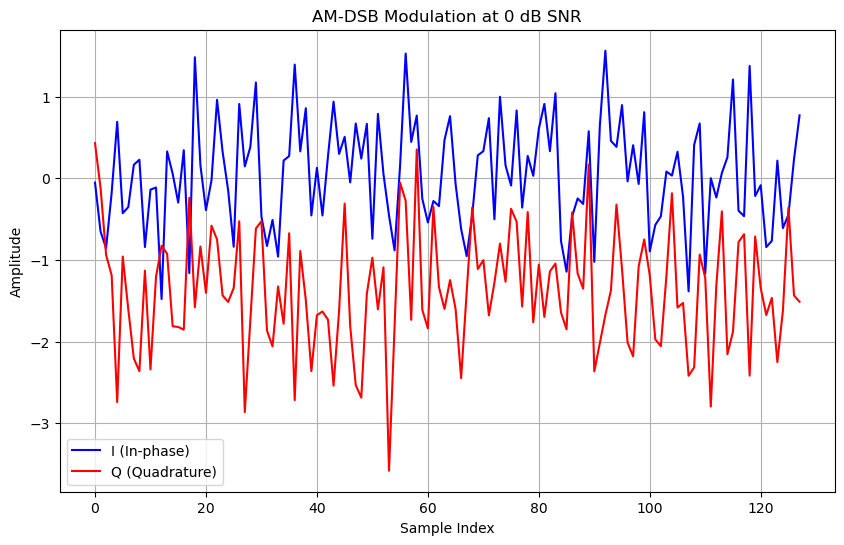

705


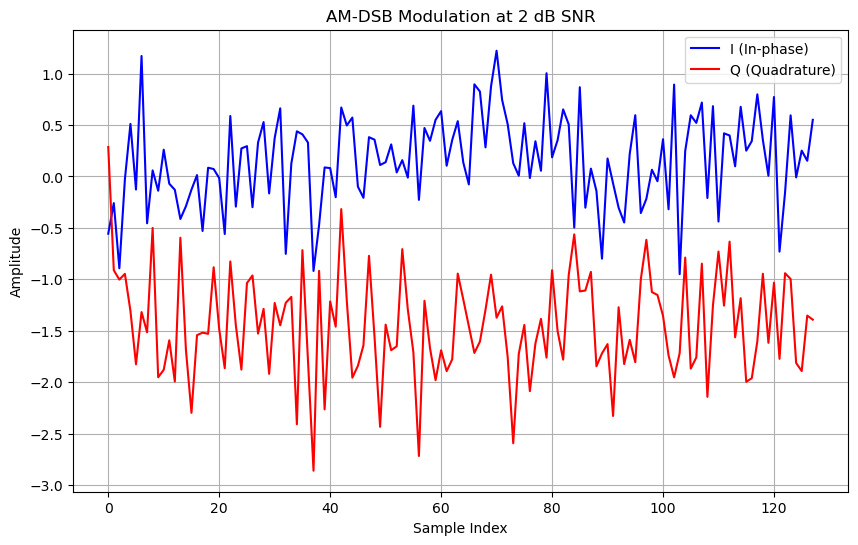

705


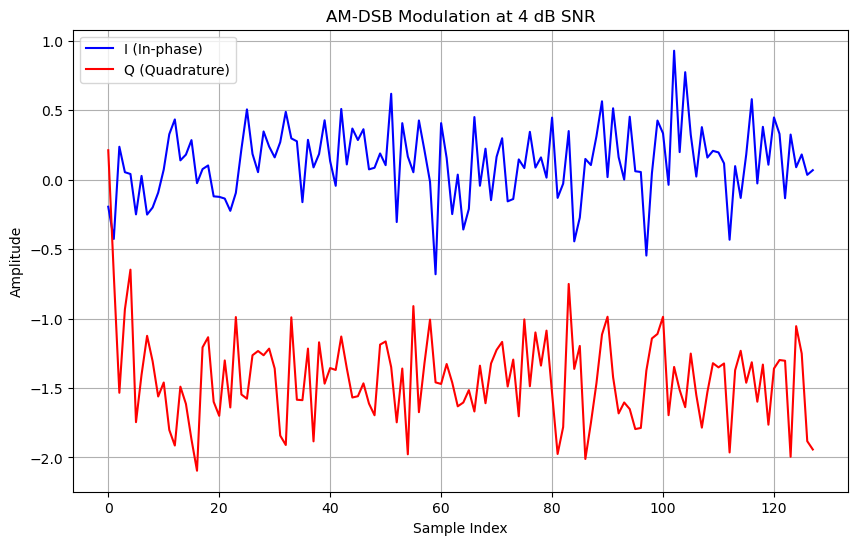

705


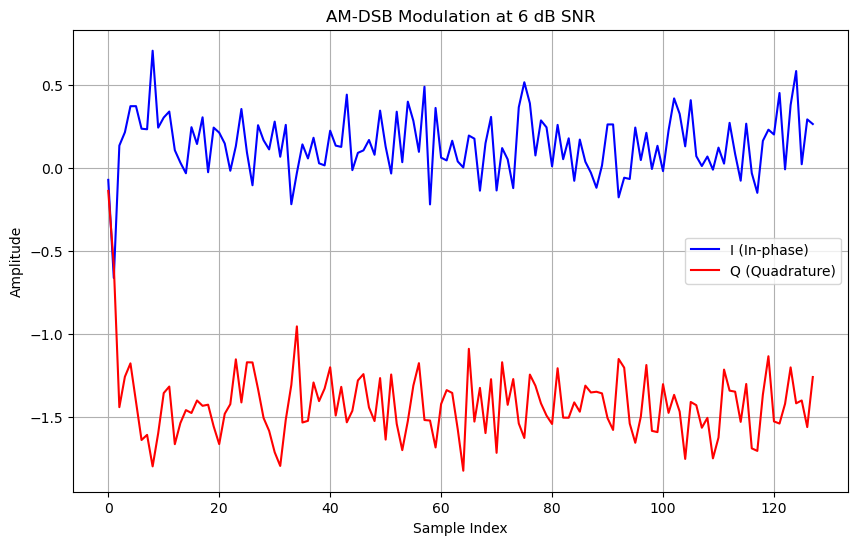

705


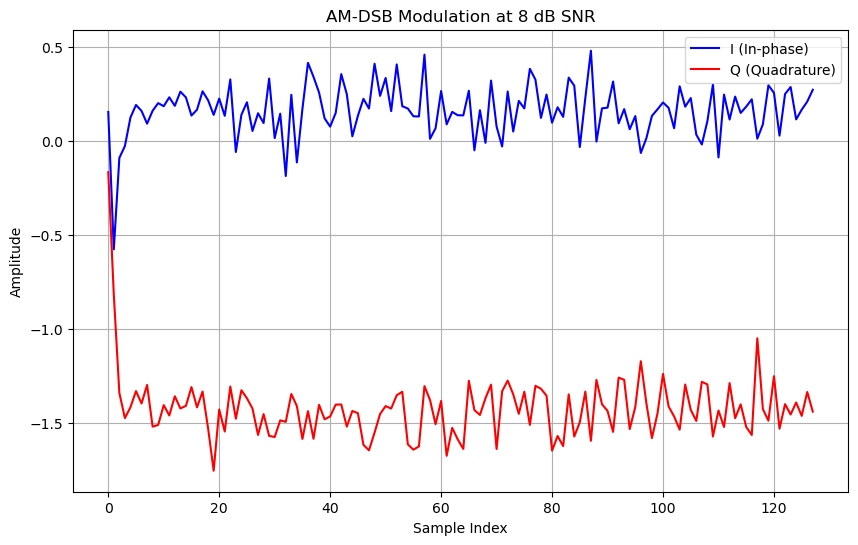

705


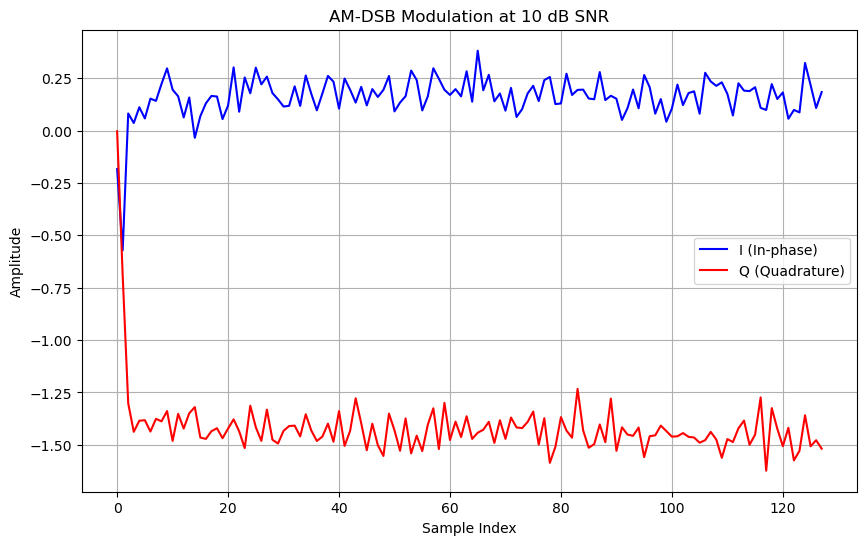

705


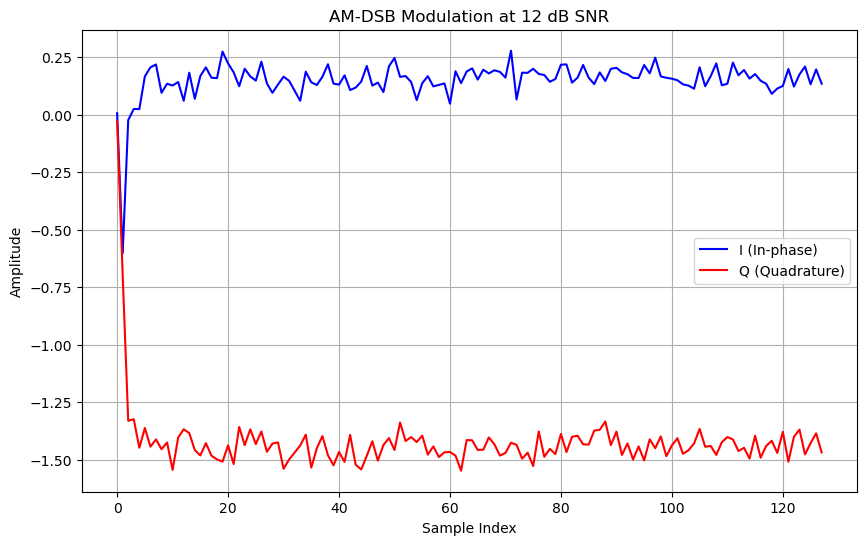

705


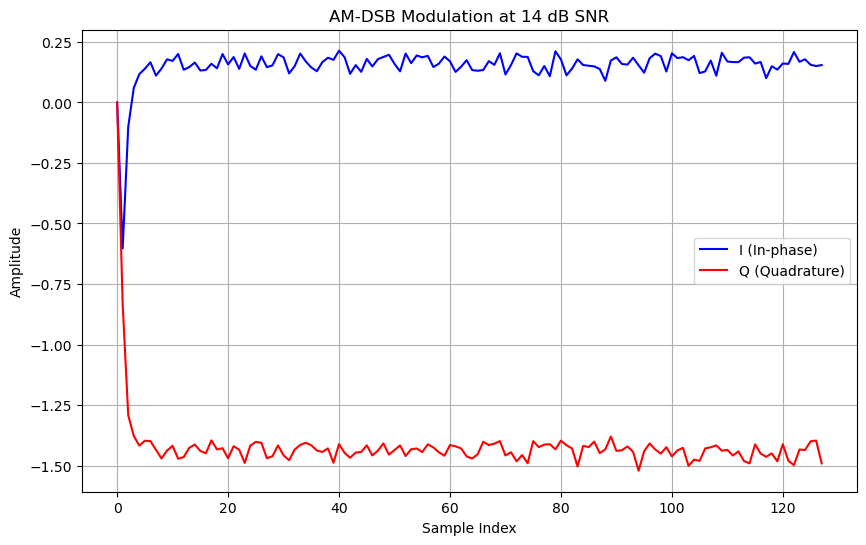

705


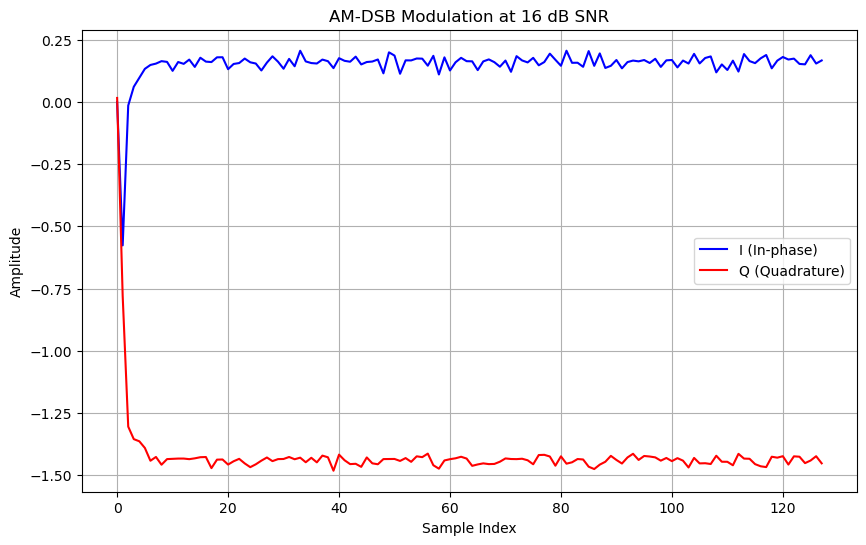

705


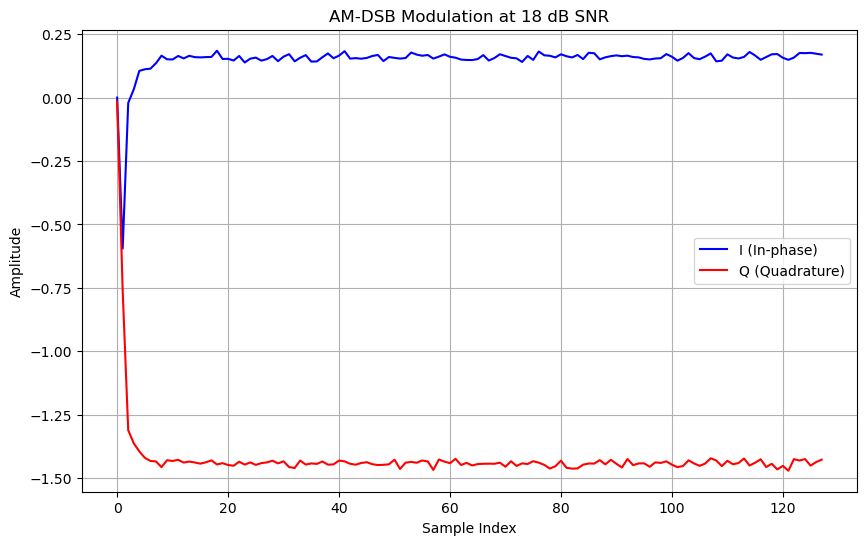

In [4]:
# Visualizing
mod_type = 'AM-DSB'

# snr_level = 6
# # samples available for the specified modulation type
# unit = 0

for snr_level in range(-20,20,2):
    # Extract data
    data_qpsk_18dB = data[(mod_type, snr_level)]
    no_samples = len(data_qpsk_18dB)
    print(no_samples)
    no_samples = 1
    
    for unit in range(no_samples):
        
        sample = data_qpsk_18dB[unit]
        # Plot I and Q components
        plt.figure(figsize=(10, 6))
        plt.plot(sample[0],'b', label='I (In-phase)')
        plt.plot(sample[1],'r', label='Q (Quadrature)')
        plt.title(f'{mod_type} Modulation at {snr_level} dB SNR')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


## Extraction & Model

In [16]:
# Load the dataset
with open('2016.04C.multisnr.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Extract features (I and Q components), labels, and SNR levels
X = []
y = []
snr = []
for key in data.keys():
    X.append(data[key])
    y.extend([key[0]] * len(data[key]))  # Modulation type
    snr.extend([key[1]] * len(data[key]))  # SNR level
X = np.vstack(X)
y = np.array(y)
snr = np.array(snr)

# Reshape X to match the expected input_shape for Conv2D
X = X.transpose(0, 2, 1)[:, :, np.newaxis]

# Convert modulation types to categorical labels
unique_mods = np.unique(y)
modulation_to_label = {mod: i for i, mod in enumerate(unique_mods)}
y = np.array([modulation_to_label[mod] for mod in y])
num_classes = len(unique_mods)

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(X, y, snr, test_size=0.2, random_state=42)


# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Reshape X_train and X_test to (samples, 2, 128, 1)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (129648, 2, 128, 1)
X_test shape: (32412, 2, 128, 1)
y_train shape: (129648, 11)
y_test shape: (32412, 11)


In [6]:
# Define the model
model = Sequential()
model.add(Conv2D(256, kernel_size=(1, 2), activation='relu', input_shape=(2, 128, 1)))
model.add(Dropout(0.25))
model.add(AveragePooling2D(pool_size=(1, 2)))
model.add(Conv2D(96, kernel_size=(1, 4), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(2, 6), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(GaussianNoise(stddev=0.1))
model.add(Dense(1024))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\Users\debab\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 2, 127, 256)         │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 127, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 2, 63, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 60, 96)           │          98,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 60, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 55, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 55, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3520)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 3520)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       3,605,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 11)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,027 (15.48 MB)

 Trainable params: 4,058,027 (15.48 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
batch_size = 128
epochs = 60
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 373s 364ms/step - accuracy: 0.2471 - loss: 2.2323 - val_accuracy: 0.5790 - val_loss: 1.0753
Epoch 2/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 243s 240ms/step - accuracy: 0.5822 - loss: 1.0992 - val_accuracy: 0.6026 - val_loss: 1.0268
Epoch 3/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 338s 334ms/step - accuracy: 0.6006 - loss: 1.0494 - val_accuracy: 0.6302 - val_loss: 0.9843
Epoch 4/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 393s 388ms/step - accuracy: 0.6105 - loss: 1.0232 - val_accuracy: 0.6182 - val_loss: 0.9690
Epoch 5/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 235s 232ms/step - accuracy: 0.6191 - loss: 0.9976 - val_accuracy: 0.6165 - val_loss: 0.9864
Epoch 6/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 236s 233ms/step - accuracy: 0.6233 - loss: 0.9887 - val_accuracy: 0.6346 - val_loss: 0.9458
Epoch 7/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 238s 235ms/step - accuracy: 0.6256 - loss: 0.9789 - val_accuracy: 0.6444 - val_loss: 0.9395
Epoch 8/60
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 282s 279ms/step - ac

In [8]:
# Make predictions
y_pred = model.predict(X_test)

1013/1013 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step


In [9]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
for i in range(len(y_true)):
    print(y_true[i],y_pred_classes[i])

10 3
9 9
7 7
6 6
1 3
1 1
5 5
0 0
4 5
5 5
0 0
0 0
1 3
4 4
10 1
3 3
8 8
6 6
1 3
6 6
1 3
6 6
6 6
1 1
3 3
1 1
3 3
4 4
8 8
8 8
5 1
1 1
0 5
5 5
5 3
9 9
5 10
4 4
5 5
9 3
1 5
2 5
3 0
5 5
4 3
5 5
3 2
3 3
4 4
10 10
4 1
10 1
7 3
3 3
0 3
5 5
3 3
5 5
5 5
5 5
0 3
3 3
1 1
3 3
10 1
5 5
1 10
6 3
5 5
10 10
3 3
6 6
3 4
5 3
3 10
4 4
7 7
8 8
0 0
6 6
3 3
1 6
5 5
10 2
9 2
5 5
2 2
4 4
2 4
10 10
10 10
5 3
5 3
10 10
10 10
2 2
0 0
2 2
3 3
7 7
10 10
3 3
10 10
9 5
3 5
8 8
5 4
1 1
2 2
4 4
9 9
6 6
6 6
3 3
3 3
3 3
10 1
3 3
3 3
0 3
4 4
3 3
1 10
1 3
5 3
9 9
3 3
2 3
1 1
3 3
3 6
10 3
4 4
2 2
3 3
1 1
2 3
3 3
5 5
0 2
0 0
3 3
10 10
0 0
5 5
5 5
4 4
9 9
5 5
6 6
4 4
4 1
6 6
2 5
5 5
6 6
3 3
5 5
4 1
1 3
6 6
4 4
5 3
6 6
3 3
7 8
4 4
4 4
4 5
5 5
3 3
10 5
0 9
0 3
3 3
5 5
7 7
10 3
6 6
4 4
3 3
1 10
3 3
10 10
3 3
5 5
0 0
1 10
9 4
4 4
4 3
5 5
2 3
1 3
1 1
10 10
0 3
10 10
0 0
6 6
3 3
5 5
6 6
10 10
7 7
5 5
3 3
6 6
5 5
8 8
4 2
9 9
3 3
3 3
7 6
6 6
2 2
5 5
10 10
1 10
5 5
1 10
3 3
0 0
6 4
2 2
3 3
3 4
10 3
1 1
0 3
6 3
9 9
0 0
9 9
9 9
9 9
7 5
2 

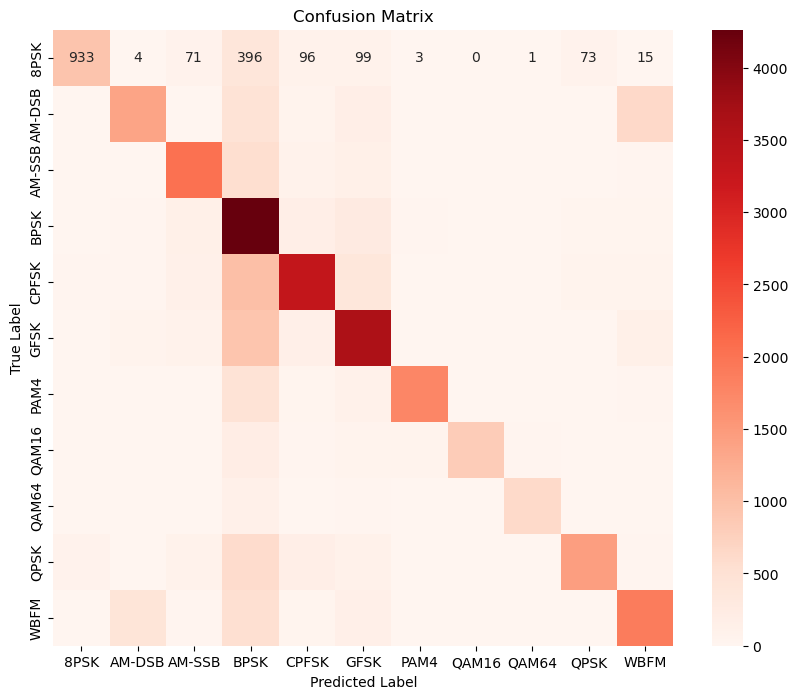

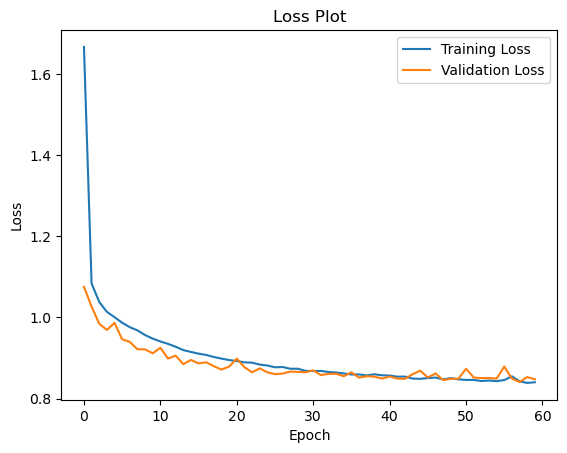

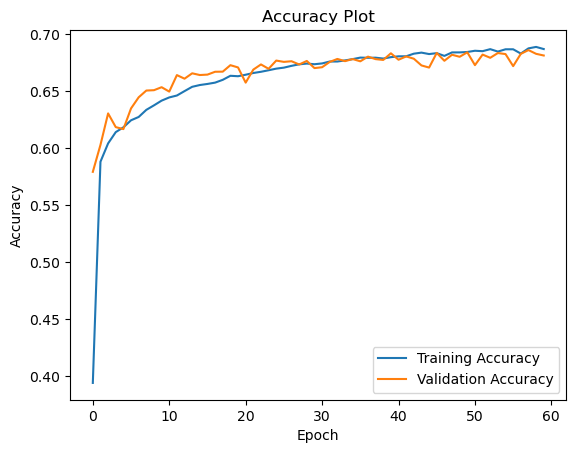

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=unique_mods, yticklabels=unique_mods)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


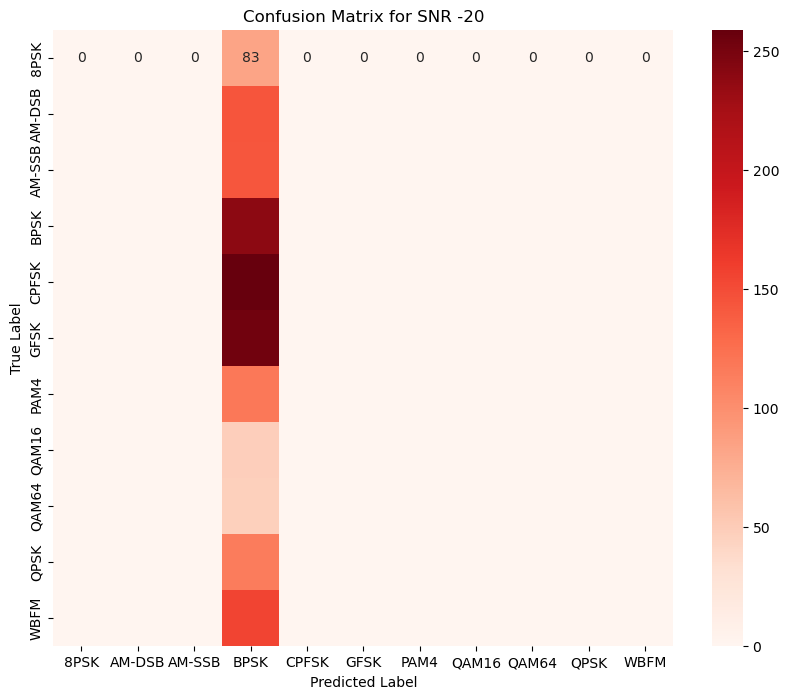

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


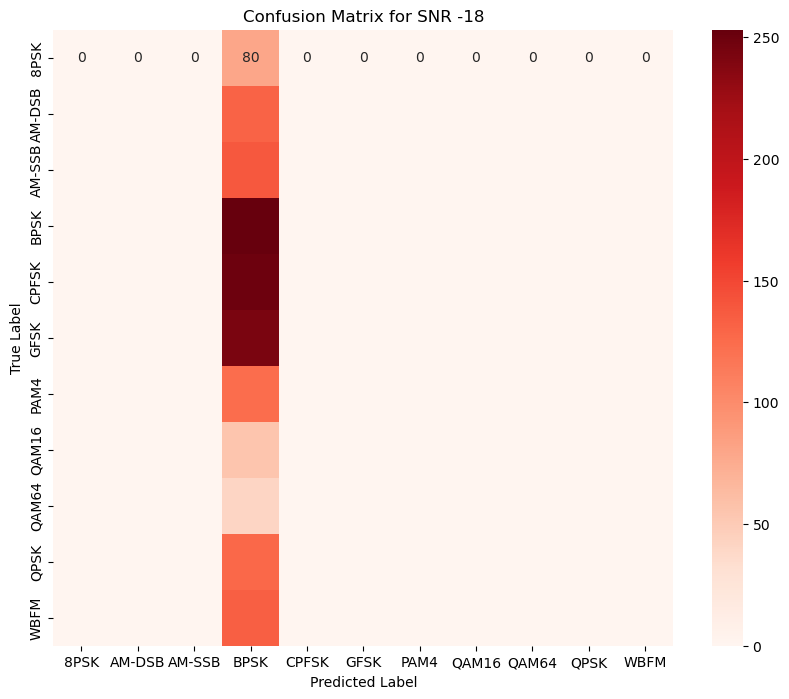

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


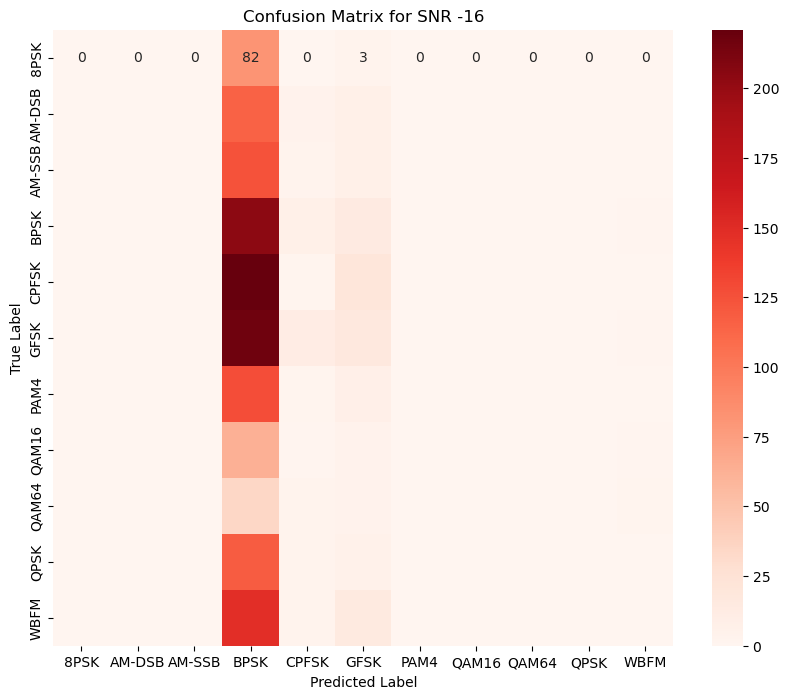

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


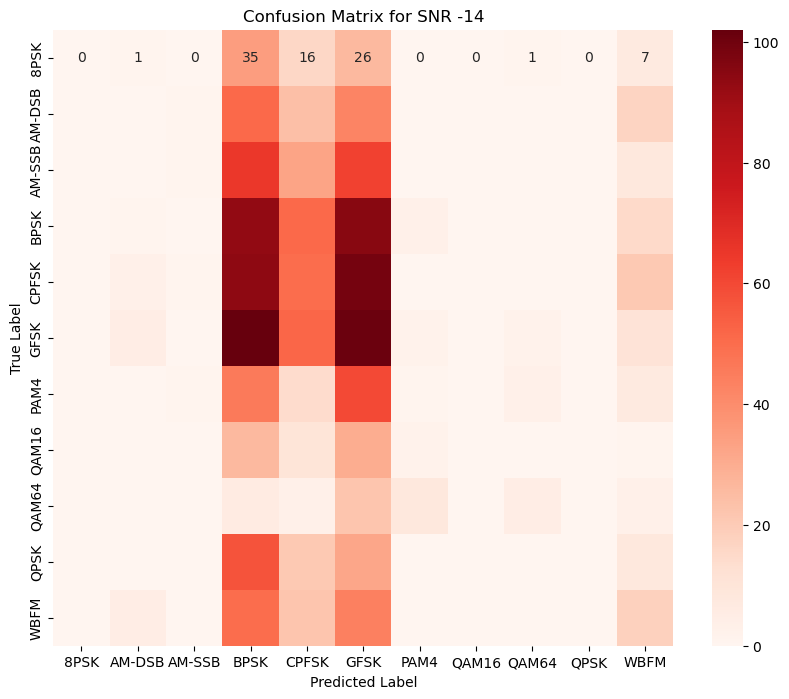

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


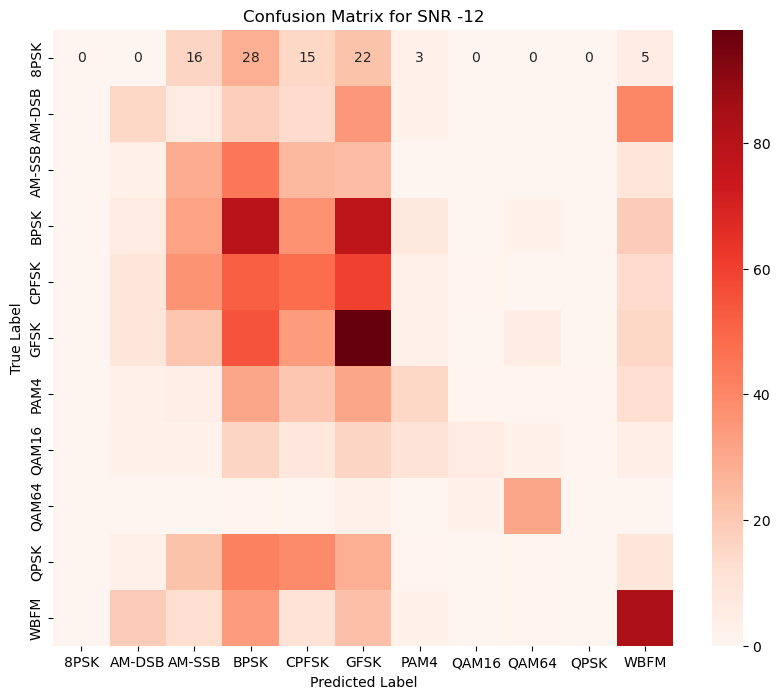

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


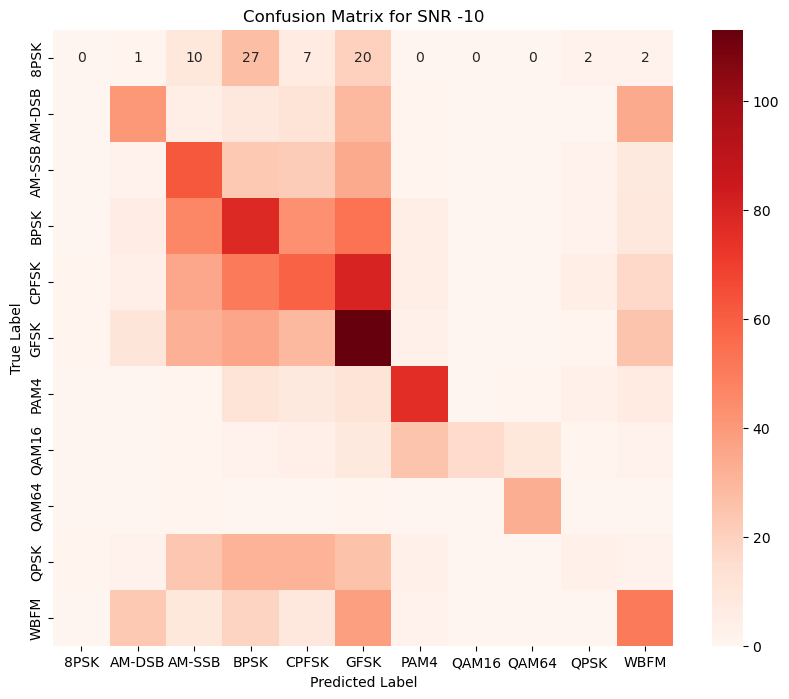

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


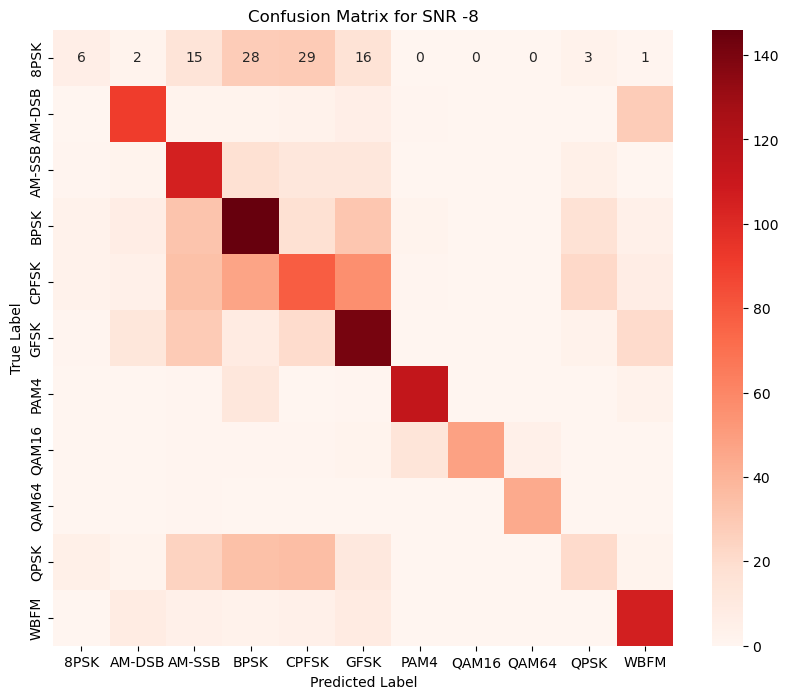

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


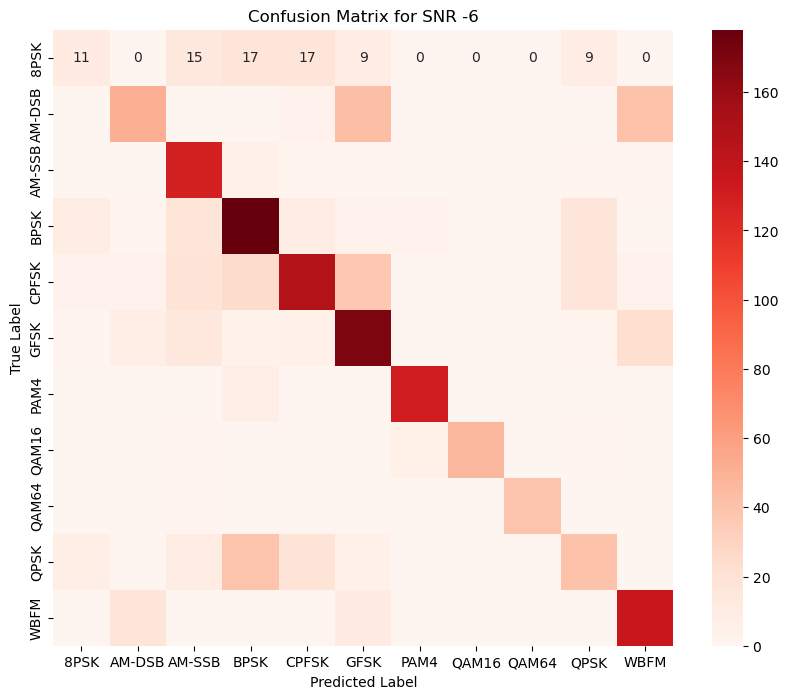

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


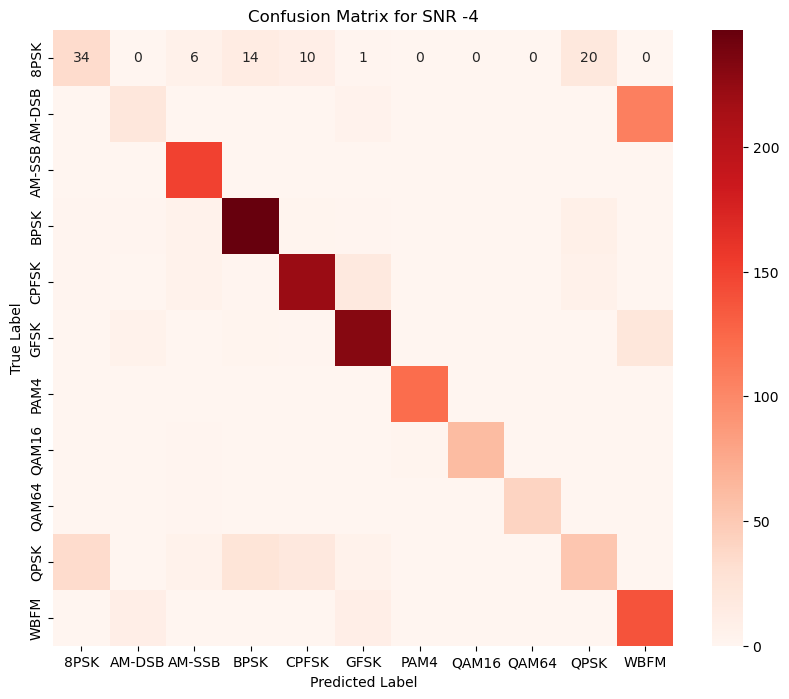

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


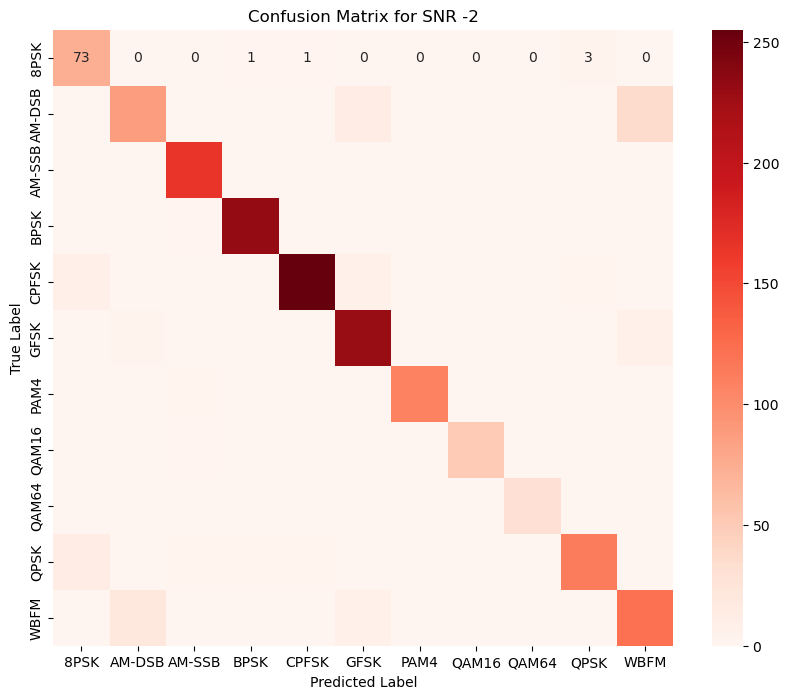

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


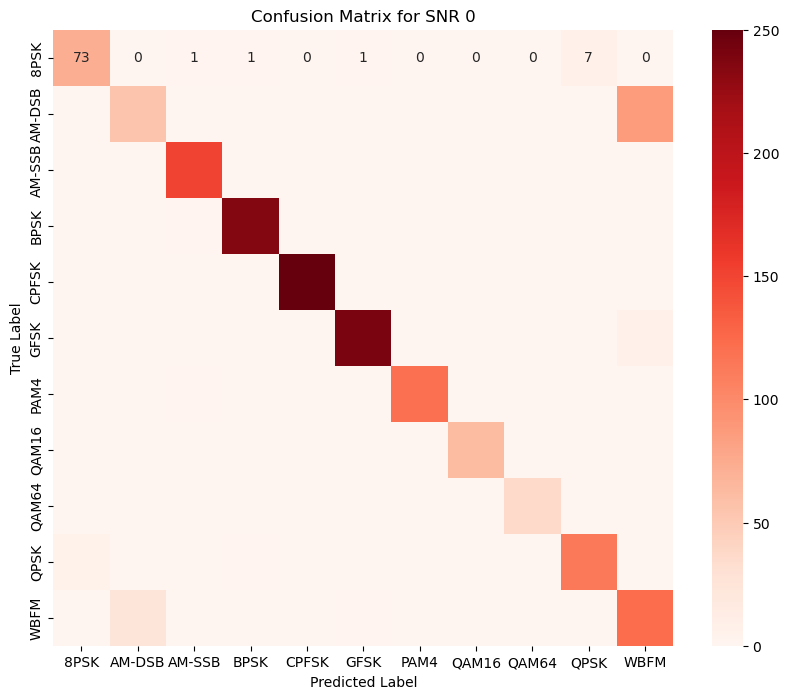

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


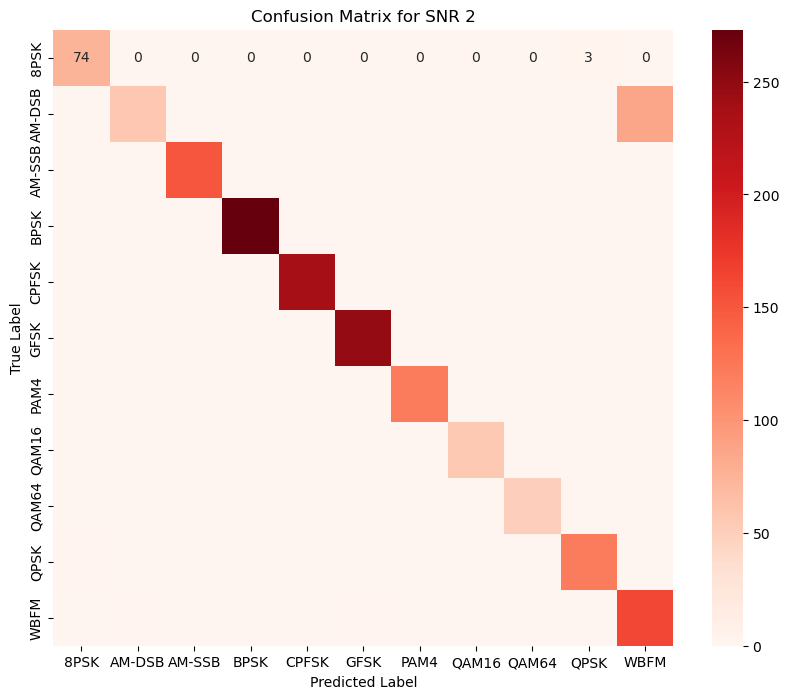

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


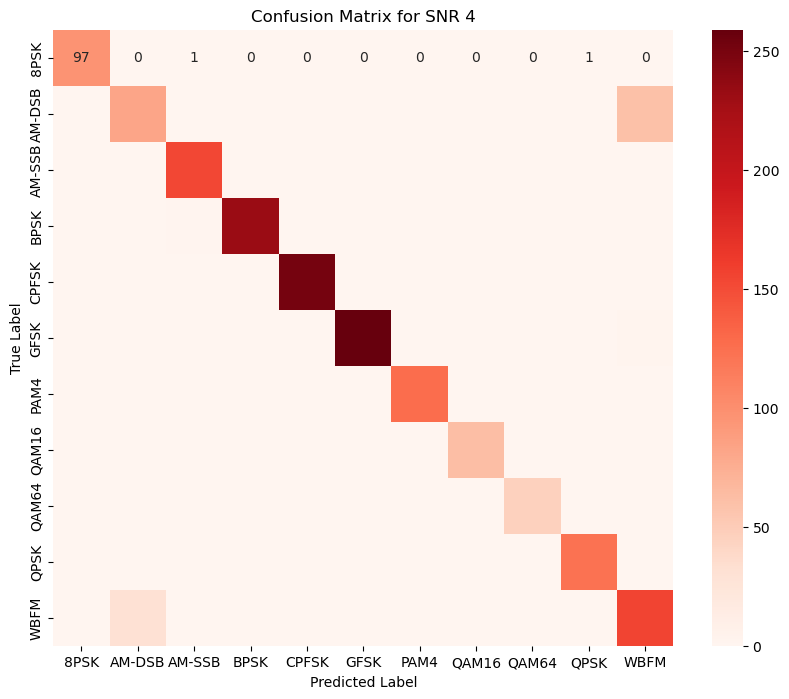

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


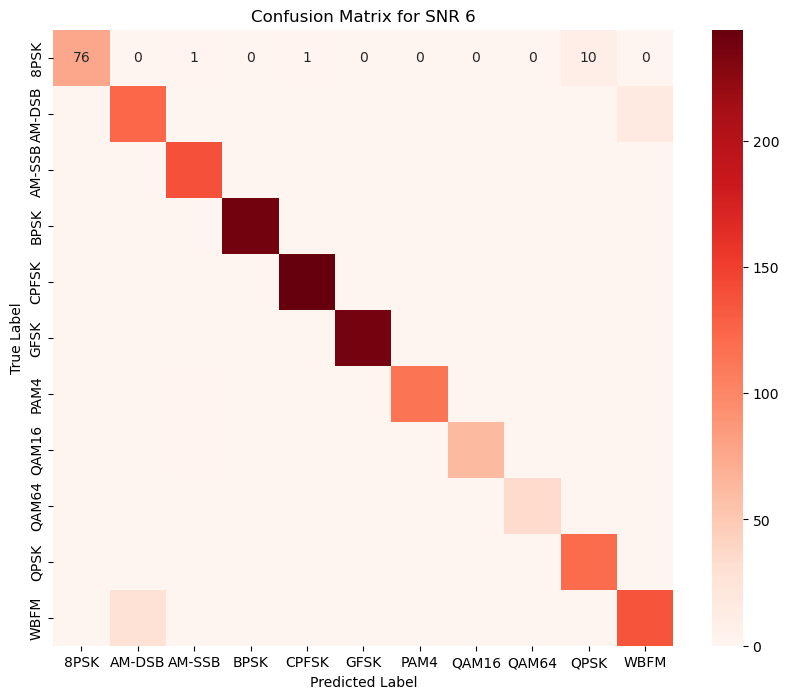

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


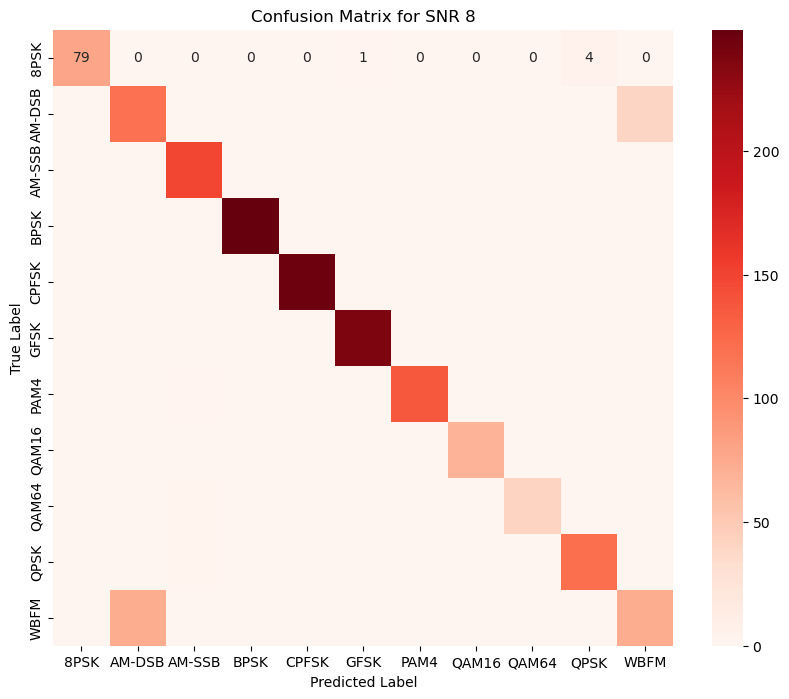

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


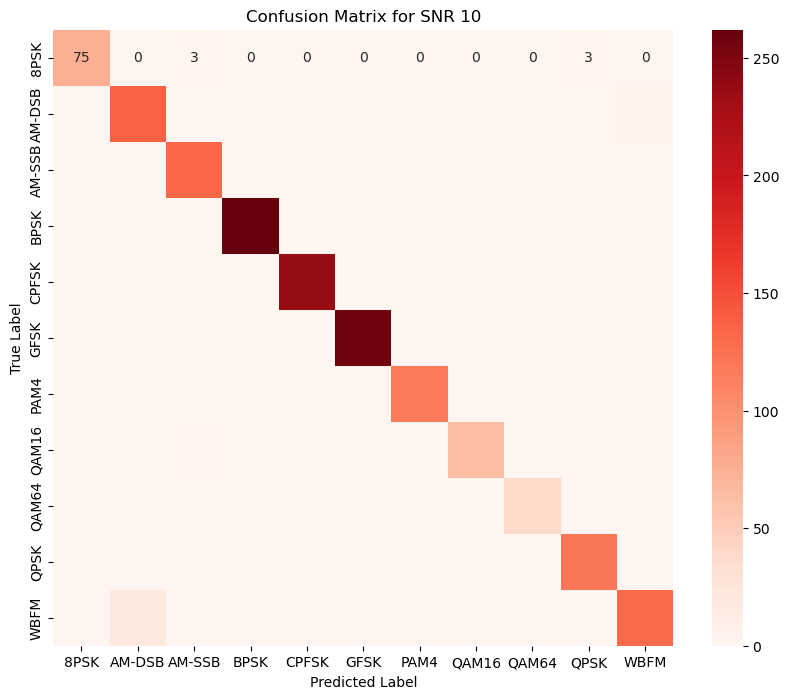

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


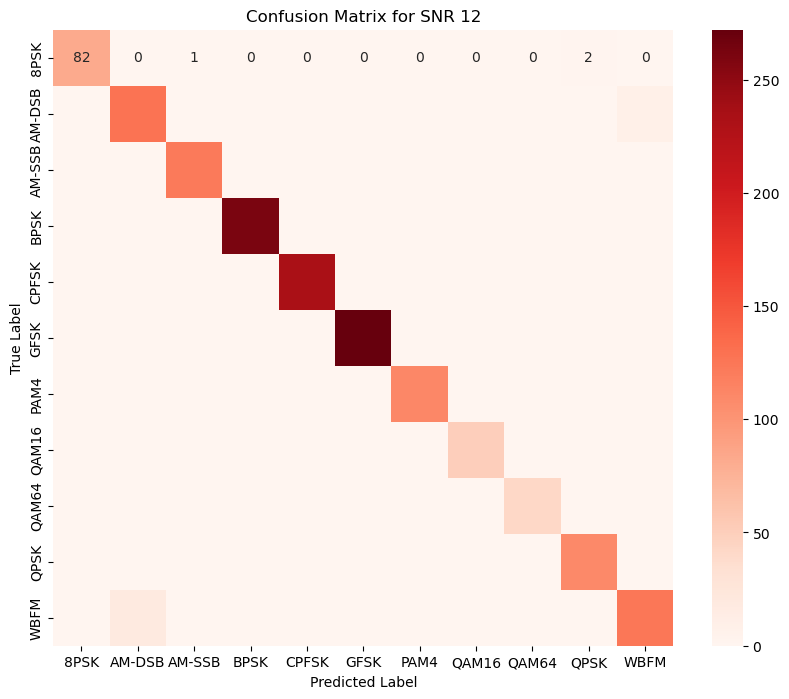

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


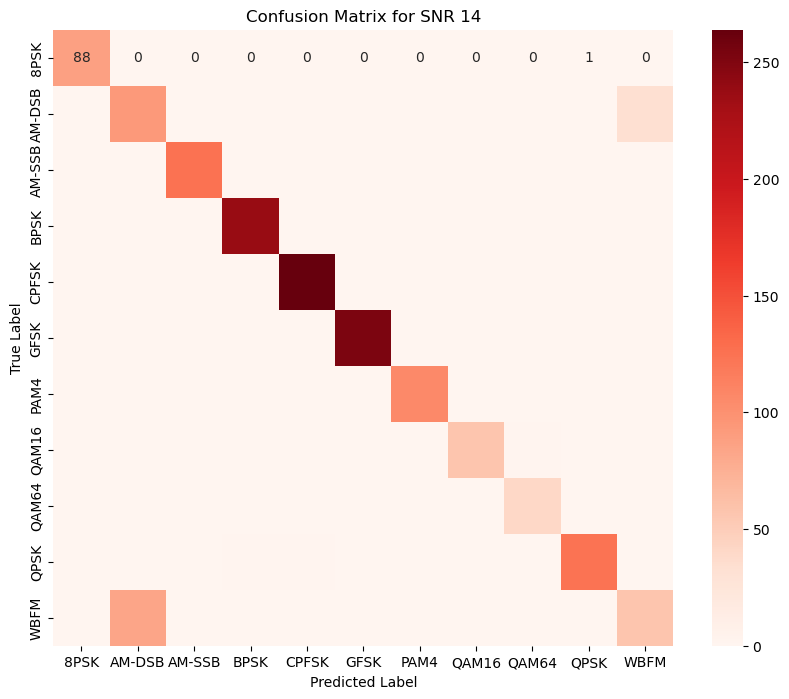

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


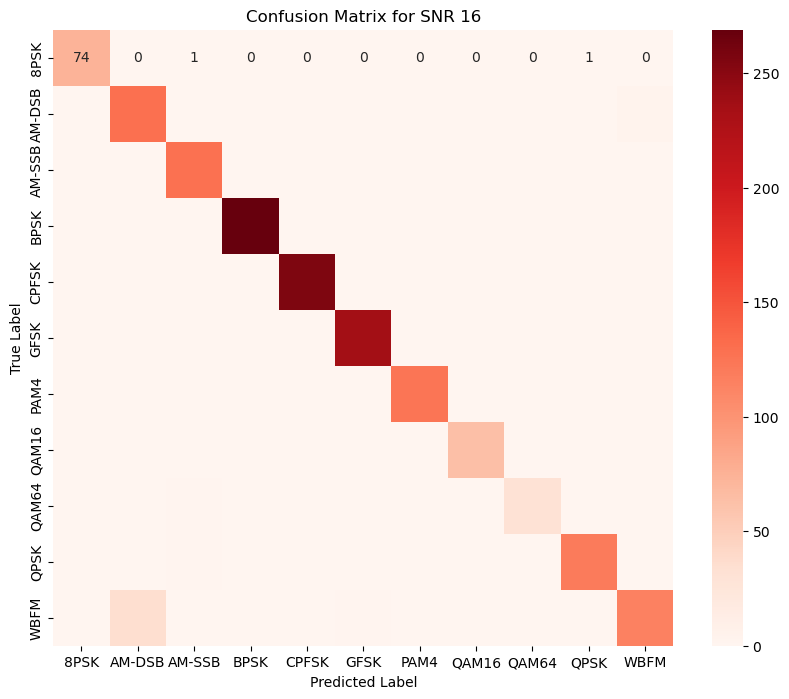

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


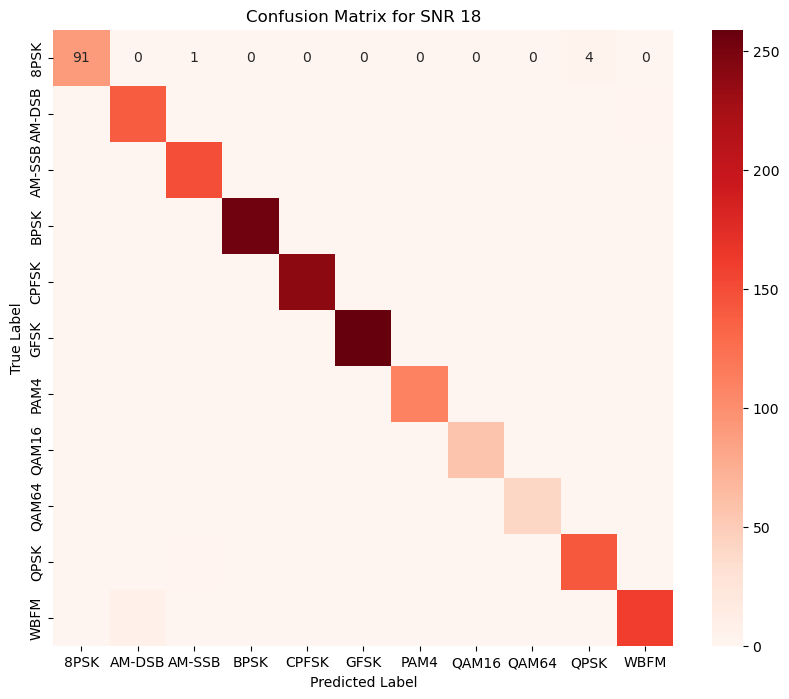

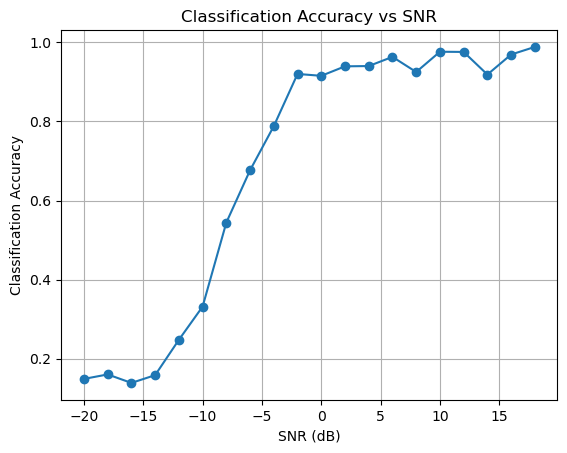

In [18]:
# Evaluate and plot confusion matrix and accuracy for each SNR level
snr_levels = np.unique(snr_test)
accuracy_per_snr = []

for snr_level in snr_levels:
    # Get data for this SNR level
    snr_indices = np.where(snr_test == snr_level)
    X_snr = X_test[snr_indices]
    y_snr_true = y_true[snr_indices]
    y_snr_test = y_test[snr_indices]

    # Make predictions
    y_snr_pred = model.predict(X_snr)
    y_snr_pred_classes = np.argmax(y_snr_pred, axis=1)

    # Calculate confusion matrix
    snr_conf_matrix = confusion_matrix(y_snr_true, y_snr_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(snr_conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=unique_mods, yticklabels=unique_mods)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for SNR {snr_level}')
    plt.show()

    # Calculate accuracy
    accuracy = np.sum(y_snr_pred_classes == y_snr_true) / len(y_snr_true)
    accuracy_per_snr.append(accuracy)

# Plot classification accuracy vs SNR
plt.figure()
plt.plot(snr_levels, accuracy_per_snr, marker='o')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs SNR')
plt.grid(True)
plt.show()